In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Hyperparameters

In [3]:
num_epochs = 1000
learning_rate = 0.001
batch_size = 16

# Generate data : I use the AWGN model to add noise

In [4]:
def awgn_channel(signal, snr_dB):
    signal_power = np.mean(np.abs(signal) ** 2)
    snr = 10 ** (snr_dB / 10)  # Conversion du SNR en échelle linéaire
    noise_power = signal_power / snr
    noise = np.random.randn(*signal.shape) * np.sqrt(noise_power)
    noisy_signal = signal + noise
    return noisy_signal

def generate_data(clean_signal, snr_dB):
    noisy_signal = awgn_channel(clean_signal, snr_dB)
    return noisy_signal

**Création d'un exemple de signal bruité :**

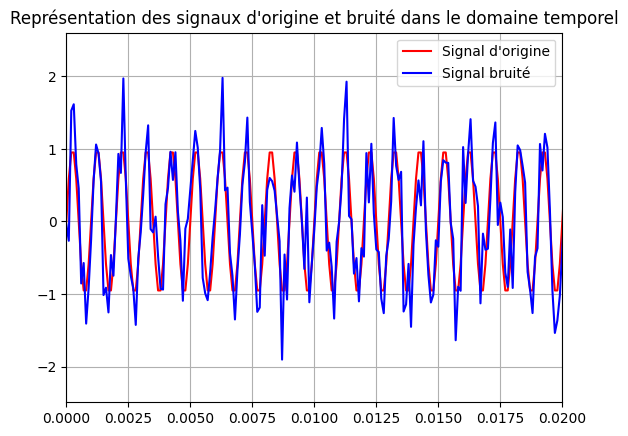

In [5]:
# Signal non bruité : 
fe = 10000
t = np.arange(0, 1, 1/fe)
clean_signal = np.sin(2 * np.pi * 1000 * t) # Fréquence 1 kHz

snr_dB = 5

noisy_signal = generate_data(clean_signal, snr_dB)
plt.plot(t, clean_signal, label = "Signal d'origine", color="r")
plt.plot(t, noisy_signal,label = "Signal bruité", color= "b")
plt.grid()
plt.title("Représentation des signaux d'origine et bruité dans le domaine temporel")
plt.legend()
plt.xlim(0,0.02)
plt.show()

In [6]:
fe = 10000
t = np.arange(0, 1, 1/fe)
num_examples = 10000
snr_levels = np.arange(1, 31, 1)

data = []

random_frequencies = np.random.uniform(500, 2500, size=num_examples)
clean_signals = np.sin(2 * np.pi * random_frequencies.reshape(-1, 1) * t)
random_snr_indices = np.random.choice(len(snr_levels), size=num_examples)
selected_snr_levels = snr_levels[random_snr_indices]

noisy_signals = []
for i in range(num_examples):
    noisy_signal = awgn_channel(clean_signals[i], selected_snr_levels[i])
    noisy_signals.append(noisy_signal)

noisy_list = [item[0] for item in data]
clean_list = [item[1] for item in data]

noisy_tensor = torch.stack([torch.Tensor(sig) for sig in noisy_signals])
clean_tensor = torch.stack([torch.Tensor(sig) for sig in clean_signals])

dataset = TensorDataset(noisy_tensor, clean_tensor)

# Split 60 % / 20 % / 20 %
train_size = int(0.6 *  len(dataset))  
val_size = int(0.2 *  len(dataset))  
test_size = len(dataset) - train_size - val_size  

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
for X,y in train_loader:
    print(X[0].shape)
    print(X.shape, y.shape)
    break

torch.Size([10000])
torch.Size([16, 10000]) torch.Size([16, 10000])


# AutoEncoder Model

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(len(t), 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.decoder = nn.Sequential(
            nn.Linear(1000, len(t)),
            nn.Dropout(0.5)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
for epoch in range(num_epochs):
    
    model.train()  
    for noisy_signals,clean_signals in train_loader:
        
        noisy_signals = noisy_signals.to(device)
        clean_signals = clean_signals.to(device)

        outputs = model(noisy_signals)

        loss = criterion(outputs, clean_signals)

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()

    model.eval()
    val_loss = 0.0
    if epoch % 100 == 0:
        with torch.no_grad():
            for noisy_signals, clean_signals in val_loader:

                noisy_signals = noisy_signals.to(device)
                clean_signals = clean_signals.to(device)

                outputs = model(noisy_signals)

                val_loss += criterion(outputs, clean_signals)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

print('Training Complete')

Epoch [1/1000], Training Loss: 0.5756, Validation Loss: 64.4058
Epoch [101/1000], Training Loss: 0.4804, Validation Loss: 60.2474
Epoch [201/1000], Training Loss: 0.4896, Validation Loss: 60.2152
Epoch [301/1000], Training Loss: 0.4822, Validation Loss: 60.1999
Epoch [401/1000], Training Loss: 0.4872, Validation Loss: 60.2277
Epoch [501/1000], Training Loss: 0.4884, Validation Loss: 60.1543
Epoch [601/1000], Training Loss: 0.4966, Validation Loss: 60.1580


In [ ]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    
    for noisy_signals, clean_signals in test_loader:
    
        noisy_signals = noisy_signals.to(device)
        clean_signals = clean_signals.to(device)
        
        outputs = model(noisy_signals)
        
        test_loss += criterion(outputs, clean_signals)

print(f'Test Loss: {test_loss.item():.4f}')

In [ ]:
fe = 10000
t = np.arange(0, 1, 1/fe)


plt.plot(t, clean_signals[0].cpu(), label = "Signal d'origine", color="r")
plt.plot(t, noisy_signals[0].cpu(),label = "Signal bruité", color= "b")
plt.plot(t, outputs[0].cpu(),label = "Signal restauré", color= "g")

plt.grid()
plt.title("Représentation des signaux d'origine et bruité dans le domaine temporel")
plt.legend()
plt.xlim(0,0.005)
plt.show()